In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from upsetplot import from_contents, plot
from matplotlib import pyplot

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# Set the font to Arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
design_matrix_test = pd.read_csv(
    "design_matrix_test_predictions.tsv",
    sep='\t'
)

In [3]:
design_matrix_val = pd.read_csv(
    "design_matrix_val_predictions.tsv",
    sep='\t'
)

In [4]:
probability_columns = [
    col for col in design_matrix_test.columns if "probability" in col and "sofa" not in col
]
probability_columns

['infection_probability',
 'abdominal_probability',
 'sst_probability',
 'lowerresp_probability',
 'uti_probability',
 'ecoli_probability',
 'bacteremia_probability']

In [5]:
clinical_columns = [
    "sao2_ambulance",
    #"oxygen_treatment_ambulance", # categorical
    #"oxygene_l_per_min_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    #"diast_bp_ambulance",
    "map_ambulance",
    "mental_status_ambulance", # categorical
    #"is_the_mental_status_impaired_ambulance", # categorical
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    "crp_day1",
    "trc_emergency_department",
    "sex",
    "age"
]

continuous_clinical_columns = [
    "sao2_ambulance",
    "resp_frequency_ambulance",
    "heart_rate_ambulance",
    "syst_bp_ambulance",
    #"diast_bp_ambulance",
    "map_ambulance",
    "temperature_ambulance",
    "crea_emergency_department",
    "bili_emergency_department",
    
    "trc_emergency_department",
    "crp_day1",
    "age"
]

categorical_clinical_columns = [
    #"oxygen_treatment_ambulance", # categorical
    "mental_status_ambulance", # categorical,
    #"sex",
    #"is_the_mental_status_impaired_ambulance", # categorical
]

In [6]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = design_matrix_test.copy()

clinical_scaler = StandardScaler()

clinical_imputer = SimpleImputer()
constant_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

X[continuous_clinical_columns] = clinical_imputer.fit_transform(X[continuous_clinical_columns])
X[categorical_clinical_columns] = constant_imputer.fit_transform(X[categorical_clinical_columns])

In [7]:
X[continuous_clinical_columns] = clinical_scaler.fit_transform(X[continuous_clinical_columns])

In [8]:
X_test = design_matrix_val.copy()

X_test[continuous_clinical_columns] = clinical_imputer.transform(X_test[continuous_clinical_columns])
X_test[categorical_clinical_columns] = constant_imputer.transform(X_test[categorical_clinical_columns])

X_test[continuous_clinical_columns] = clinical_scaler.transform(X_test[continuous_clinical_columns])

In [9]:
X_subset = X.copy()

In [10]:
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def plot_results(X_input):

    sepsis_range = X_input['Sepsis Diagnosis Probability'].unique()
    sepsis_range.sort()
    actual_sepsis_rate = []

    print(sepsis_range)
    for val in sepsis_range:

        print(val)
        counts = X_input[X_input['Sepsis Diagnosis Probability'] == val]['sepsis_or_septic_shock'].value_counts()

        print()
        actual_sepsis_rate.append(counts.get(1, 0) / (counts.get(0, 0) + counts.get(1, 0)))
        print(counts)
        print()

    estimated_sepsis = pd.DataFrame(
        {
            "Actual Sepsis Rate": actual_sepsis_rate,
            "Estimated Sepsis Rate": sepsis_range
        }
    )

    # linreg = LinearRegression()

    # linreg.fit(estimated_sepsis[['Estimated Sepsis Rate']], estimated_sepsis[['Actual Sepsis Rate']])

    linregress_results = linregress(estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel())
    
    predictions = linregress_results.intercept + linregress_results.slope*estimated_sepsis[['Estimated Sepsis Rate']].values.ravel()

    corr, pval = pearsonr(
        estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(), estimated_sepsis[['Actual Sepsis Rate']].values.ravel()
    )

    return estimated_sepsis, linregress_results, predictions, corr, pval

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
0.2

sepsis_or_septic_shock
0.0    1
Name: count, dtype: int64

0.3

sepsis_or_septic_shock
0.0    6
1.0    4
Name: count, dtype: int64

0.4

sepsis_or_septic_shock
1.0    8
0.0    8
Name: count, dtype: int64

0.5

sepsis_or_septic_shock
1.0    17
0.0    13
Name: count, dtype: int64

0.6

sepsis_or_septic_shock
1.0    23
0.0    18
Name: count, dtype: int64

0.7

sepsis_or_septic_shock
1.0    48
0.0    24
Name: count, dtype: int64

0.8

sepsis_or_septic_shock
1.0    30
0.0    15
Name: count, dtype: int64

0.9

sepsis_or_septic_shock
1.0    29
0.0     8
Name: count, dtype: int64

1.0

sepsis_or_septic_shock
1.0    6
0.0    6
Name: count, dtype: int64



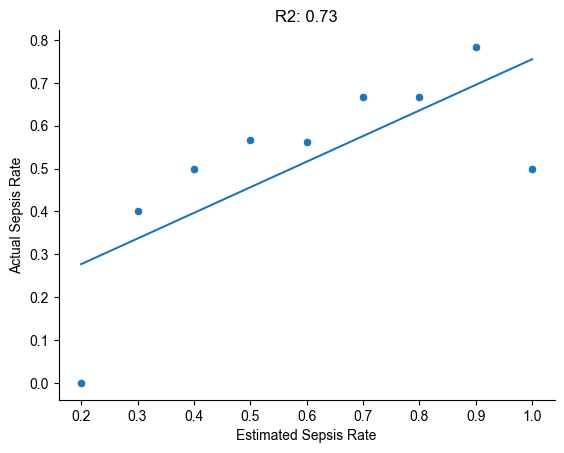

In [11]:
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(
    n_neighbors=10,
    metric="euclidean"
)

neighbors.fit(X_subset[probability_columns])

distances, knn_results = neighbors.kneighbors(X_test[probability_columns], return_distance=True)

errors = []

neighborhood_sizes = []

mean_distance = []

#sofa_predicted_values = []

sepsis_diagnosis = []
sepsis_developments = []

sepsis_votes = []

for i in range(knn_results.shape[0]):

    #if distances[i].max() < distances.mean():

    knn_idx = knn_results[i, :]

    if knn_idx.size > 0:

        neighborhood = X_subset.iloc[knn_idx, :].copy()

        neighborhood_sizes.append(neighborhood.shape[0])

        weights = 1 / distances[i]

        weights = weights / np.sum(weights)

        mean_distance.append(
            distances[i].mean()
        )

        sepsis_development = np.where(
            neighborhood['sepsis_or_septic_shock'] == 1, 1, 0
        )

        sepsis_development_prob = sepsis_development.sum() / neighborhood.shape[0]

        sepsis_developments.append(sepsis_development_prob)

        weighted_votes = sepsis_development * weights
        weighted_vote = np.sum(weighted_votes)
        sepsis_votes.append(weighted_vote)


    else:

        print(i)

        errors.append(np.NaN)

        neighborhood_sizes.append(np.NaN)

        mean_distance.append(np.NaN)

X_test['Sepsis Diagnosis Probability'] = sepsis_developments
X_test['Sepsis Votes'] = sepsis_votes


fig, ax = plt.subplots()

protein_estimated_sepsis, protein_linregress_results, protein_predictions, protein_corr, protein_pval = plot_results(X_test)


sns.scatterplot(
    data=protein_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax
)

sns.lineplot(
    x=protein_estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(),
    y=protein_predictions,
    ax=ax
)

ax.set_title(
    f"R2: {protein_linregress_results.rvalue:.2f}"
)

sns.despine()

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
0.1

sepsis_or_septic_shock
0.0    4
Name: count, dtype: int64

0.2

sepsis_or_septic_shock
0.0    5
1.0    1
Name: count, dtype: int64

0.3

sepsis_or_septic_shock
0.0    10
1.0     4
Name: count, dtype: int64

0.4

sepsis_or_septic_shock
0.0    10
1.0     5
Name: count, dtype: int64

0.5

sepsis_or_septic_shock
1.0    18
0.0    16
Name: count, dtype: int64

0.6

sepsis_or_septic_shock
1.0    17
0.0    14
Name: count, dtype: int64

0.7

sepsis_or_septic_shock
1.0    30
0.0    17
Name: count, dtype: int64

0.8

sepsis_or_septic_shock
1.0    39
0.0    10
Name: count, dtype: int64

0.9

sepsis_or_septic_shock
1.0    34
0.0    10
Name: count, dtype: int64

1.0

sepsis_or_septic_shock
1.0    17
0.0     3
Name: count, dtype: int64



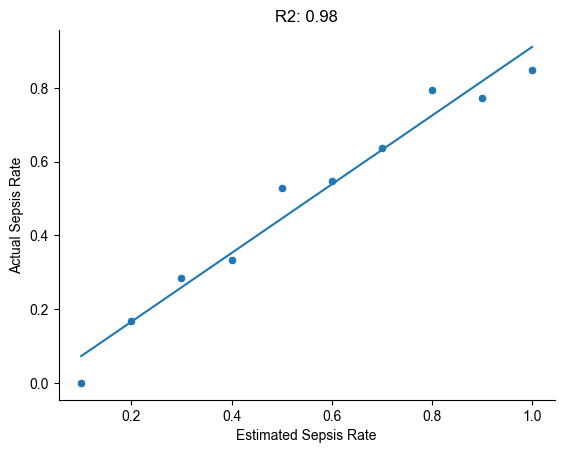

In [12]:
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(
    n_neighbors=10,
    metric="euclidean"
)

neighbors.fit(X_subset[clinical_columns])

distances, knn_results = neighbors.kneighbors(X_test[clinical_columns], return_distance=True)

errors = []

neighborhood_sizes = []

mean_distance = []

#sofa_predicted_values = []

sepsis_diagnosis = []
sepsis_developments = []

sepsis_votes = []

for i in range(knn_results.shape[0]):

    #if distances[i].max() < distances.mean():

    knn_idx = knn_results[i, :]

    if knn_idx.size > 0:

        neighborhood = X_subset.iloc[knn_idx, :].copy()

        neighborhood_sizes.append(neighborhood.shape[0])

        weights = 1 / distances[i]

        weights = weights / np.sum(weights)

        mean_distance.append(
            distances[i].mean()
        )

        sepsis_development = np.where(
            neighborhood['sepsis_or_septic_shock'] == 1, 1, 0
        )

        sepsis_development_prob = sepsis_development.sum() / neighborhood.shape[0]

        sepsis_developments.append(sepsis_development_prob)

        weighted_votes = sepsis_development * weights
        weighted_vote = np.sum(weighted_votes)
        sepsis_votes.append(weighted_vote)


    else:

        print(i)

        errors.append(np.NaN)

        neighborhood_sizes.append(np.NaN)

        mean_distance.append(np.NaN)

X_test['Sepsis Diagnosis Probability'] = sepsis_developments
X_test['Sepsis Votes'] = sepsis_votes

fig, ax = plt.subplots()

clinical_estimated_sepsis, clinical_linregress_results, clinical_predictions, clinical_corr, clinical_pval = plot_results(X_test)


sns.scatterplot(
    data=clinical_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax
)

sns.lineplot(
    x=clinical_estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(),
    y=clinical_predictions,
    ax=ax
)

ax.set_title(
    f"R2: {clinical_linregress_results.rvalue:.2f}"
)

sns.despine()

In [13]:

clinical_columns.extend(probability_columns)
clinical_columns

['sao2_ambulance',
 'resp_frequency_ambulance',
 'heart_rate_ambulance',
 'syst_bp_ambulance',
 'map_ambulance',
 'mental_status_ambulance',
 'temperature_ambulance',
 'crea_emergency_department',
 'bili_emergency_department',
 'crp_day1',
 'trc_emergency_department',
 'sex',
 'age',
 'infection_probability',
 'abdominal_probability',
 'sst_probability',
 'lowerresp_probability',
 'uti_probability',
 'ecoli_probability',
 'bacteremia_probability']

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
0.1

sepsis_or_septic_shock
0.0    3
Name: count, dtype: int64

0.2

sepsis_or_septic_shock
0.0    8
1.0    3
Name: count, dtype: int64

0.3

sepsis_or_septic_shock
0.0    10
1.0     1
Name: count, dtype: int64

0.4

sepsis_or_septic_shock
0.0    14
1.0     6
Name: count, dtype: int64

0.5

sepsis_or_septic_shock
1.0    17
0.0    11
Name: count, dtype: int64

0.6

sepsis_or_septic_shock
1.0    17
0.0    13
Name: count, dtype: int64

0.7

sepsis_or_septic_shock
1.0    29
0.0    18
Name: count, dtype: int64

0.8

sepsis_or_septic_shock
1.0    37
0.0    10
Name: count, dtype: int64

0.9

sepsis_or_septic_shock
1.0    38
0.0     9
Name: count, dtype: int64

1.0

sepsis_or_septic_shock
1.0    17
0.0     3
Name: count, dtype: int64



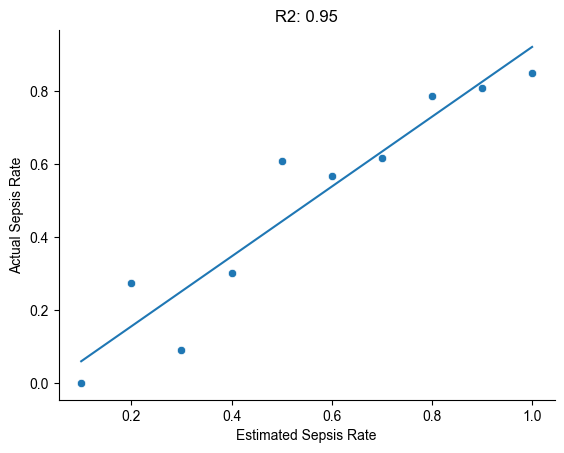

In [14]:
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(
    n_neighbors=10,
    metric="euclidean"
)

neighbors.fit(X_subset[clinical_columns])

distances, knn_results = neighbors.kneighbors(X_test[clinical_columns], return_distance=True)

errors = []

neighborhood_sizes = []

mean_distance = []

#sofa_predicted_values = []

sepsis_diagnosis = []
sepsis_developments = []

sepsis_votes = []

for i in range(knn_results.shape[0]):

    #if distances[i].max() < distances.mean():

    knn_idx = knn_results[i, :]

    if knn_idx.size > 0:

        neighborhood = X_subset.iloc[knn_idx, :].copy()

        neighborhood_sizes.append(neighborhood.shape[0])

        weights = 1 / distances[i]

        weights = weights / np.sum(weights)

        mean_distance.append(
            distances[i].mean()
        )

        sepsis_development = np.where(
            neighborhood['sepsis_or_septic_shock'] == 1, 1, 0
        )

        sepsis_development_prob = sepsis_development.sum() / neighborhood.shape[0]

        sepsis_developments.append(sepsis_development_prob)

        weighted_votes = sepsis_development * weights
        weighted_vote = np.sum(weighted_votes)
        sepsis_votes.append(weighted_vote)


    else:

        print(i)

        errors.append(np.NaN)

        neighborhood_sizes.append(np.NaN)

        mean_distance.append(np.NaN)

X_test['Sepsis Diagnosis Probability'] = sepsis_developments
X_test['Sepsis Votes'] = sepsis_votes

fig, ax = plt.subplots()

combined_estimated_sepsis, combined_linregress_results, combined_predictions, combined_corr, combined_pval = plot_results(X_test)

sns.scatterplot(
    data=combined_estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    ax=ax
)

sns.lineplot(
    x=combined_estimated_sepsis[['Estimated Sepsis Rate']].values.ravel(),
    y=combined_predictions,
    ax=ax
)

ax.set_title(
    f"R2: {combined_linregress_results.rvalue:.2f}"
)

sns.despine()

In [15]:
protein_estimated_sepsis['Label'] = "Protein"
clinical_estimated_sepsis['Label'] = "Clinical"
combined_estimated_sepsis['Label'] = "Combined"

In [16]:
protein_estimated_sepsis['Predictions'] = protein_predictions
clinical_estimated_sepsis['Predictions'] = clinical_predictions
combined_estimated_sepsis['Predictions'] = combined_predictions
combined_estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Label,Predictions
0,0.000000,0.1,Combined,0.059311
1,0.272727,0.2,Combined,0.155025
2,0.090909,0.3,Combined,0.250738
3,0.300000,0.4,Combined,0.346451
4,0.607143,0.5,Combined,0.442165
5,0.566667,0.6,Combined,0.537878
6,0.617021,0.7,Combined,0.633591
7,0.787234,0.8,Combined,0.729304
8,0.808511,0.9,Combined,0.825018
9,0.850000,1.0,Combined,0.920731


In [17]:
estimated_sepsis = pd.concat(
    [
        protein_estimated_sepsis,
        clinical_estimated_sepsis,
        combined_estimated_sepsis
    ]
)
estimated_sepsis

,Actual Sepsis Rate,Estimated Sepsis Rate,Label,Predictions
0,0.000000,0.2,Protein,0.277105
1,0.400000,0.3,Protein,0.336850
2,0.500000,0.4,Protein,0.396595
3,0.566667,0.5,Protein,0.456340
4,0.560976,0.6,Protein,0.516084
5,0.666667,0.7,Protein,0.575829
6,0.666667,0.8,Protein,0.635574
7,0.783784,0.9,Protein,0.695319
8,0.500000,1.0,Protein,0.755063
0,0.000000,0.1,Clinical,0.072664


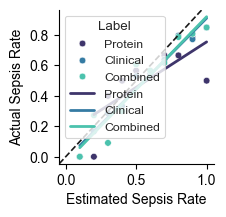

In [18]:
fig, ax = plt.subplots()

sns.set_theme(context="paper", style="white")

sns.scatterplot(
    data=estimated_sepsis,
    x="Estimated Sepsis Rate",
    y="Actual Sepsis Rate",
    hue="Label",
    palette="mako",
    #s=100,
    ax=ax
)

sns.lineplot(
    data=estimated_sepsis,
    x='Estimated Sepsis Rate',
    y="Predictions",
    hue="Label",
    palette="mako",
    lw=2,
    ax=ax
)

ax.axline((0, 0), slope=1, color='k', linestyle='--')

sns.despine()

# ax.set_title(
#     f"R2: {combined_linregress_results.rvalue:.2f}\n
#     "
# )

ax.figure.set_size_inches((2, 2))


In [19]:
ax.figure.savefig(
    "digital_family_sepsis_infection.pdf", dpi=300, bbox_inches="tight"
)